# Exercises

In [1]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
import seaborn as sns
import pickle
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data

## Exercise 1 - simulating place cells
---
Use the code we build to simulate place cells in the lesson.

A - Explore what happens when you change the binning in the definition of the firing rate maps (`space_bins`). Make it coarser or broader. 


B - In the spike train simulations, we add some "baseline" noise, not place-related to the firing. Which variable determines the noise level? Try to experiment with that variable and see what happens to the firing rate maps. What is the best approach to firing rate maps when the noise is high.


C - We could use other approaches to firing rate maps: for example make the binning very small (down to 1 cm, which is the resolution of our "video" data, and then applying a gaussian smoother. Scipy has a Gaussian smoother at `scipy.stats.gaussian_kde`. Read the documentation for that function and apply it to the data to define the smoothed firing rate maps. Again, change the noise levels and see how the smoother changes. 

D - When analyzing place fields, two important quantities are the place field center and the place field width. The place field center may be defined in many ways, but one is to compute the "center of mass" of the spikes according to the equation 

$$ c_{pf} = \frac{1}{N_{spikes}} \sum_{i} L_i $$ 

where the sum on $i$ runs on all spikes emitted by a cell and $L_i$ is the location at which the i-th spike was emitted. Calculate this for each cell. Compare with the "true" place field centers from the simulations (which variables are we talking about?) 


In [3]:
# Simulate place cells
track_length = 200. # the length of the linear track in cm 
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # number of cells recorded
pf_centers = np.random.rand(n_cells) * track_length # centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
    
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second, i.e. animal position 30 times per second
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0. # effectively same as using a np.zeros; for flexibility 
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.) #other end of track = last bin
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps

sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x)) # interpolate here because there are more neural positions than video positions, due to fps = 30
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate # add constant noise firing here
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc) 
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

spike_positions = [np.interp(s, t, x) for s in spikes]

100%|█████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


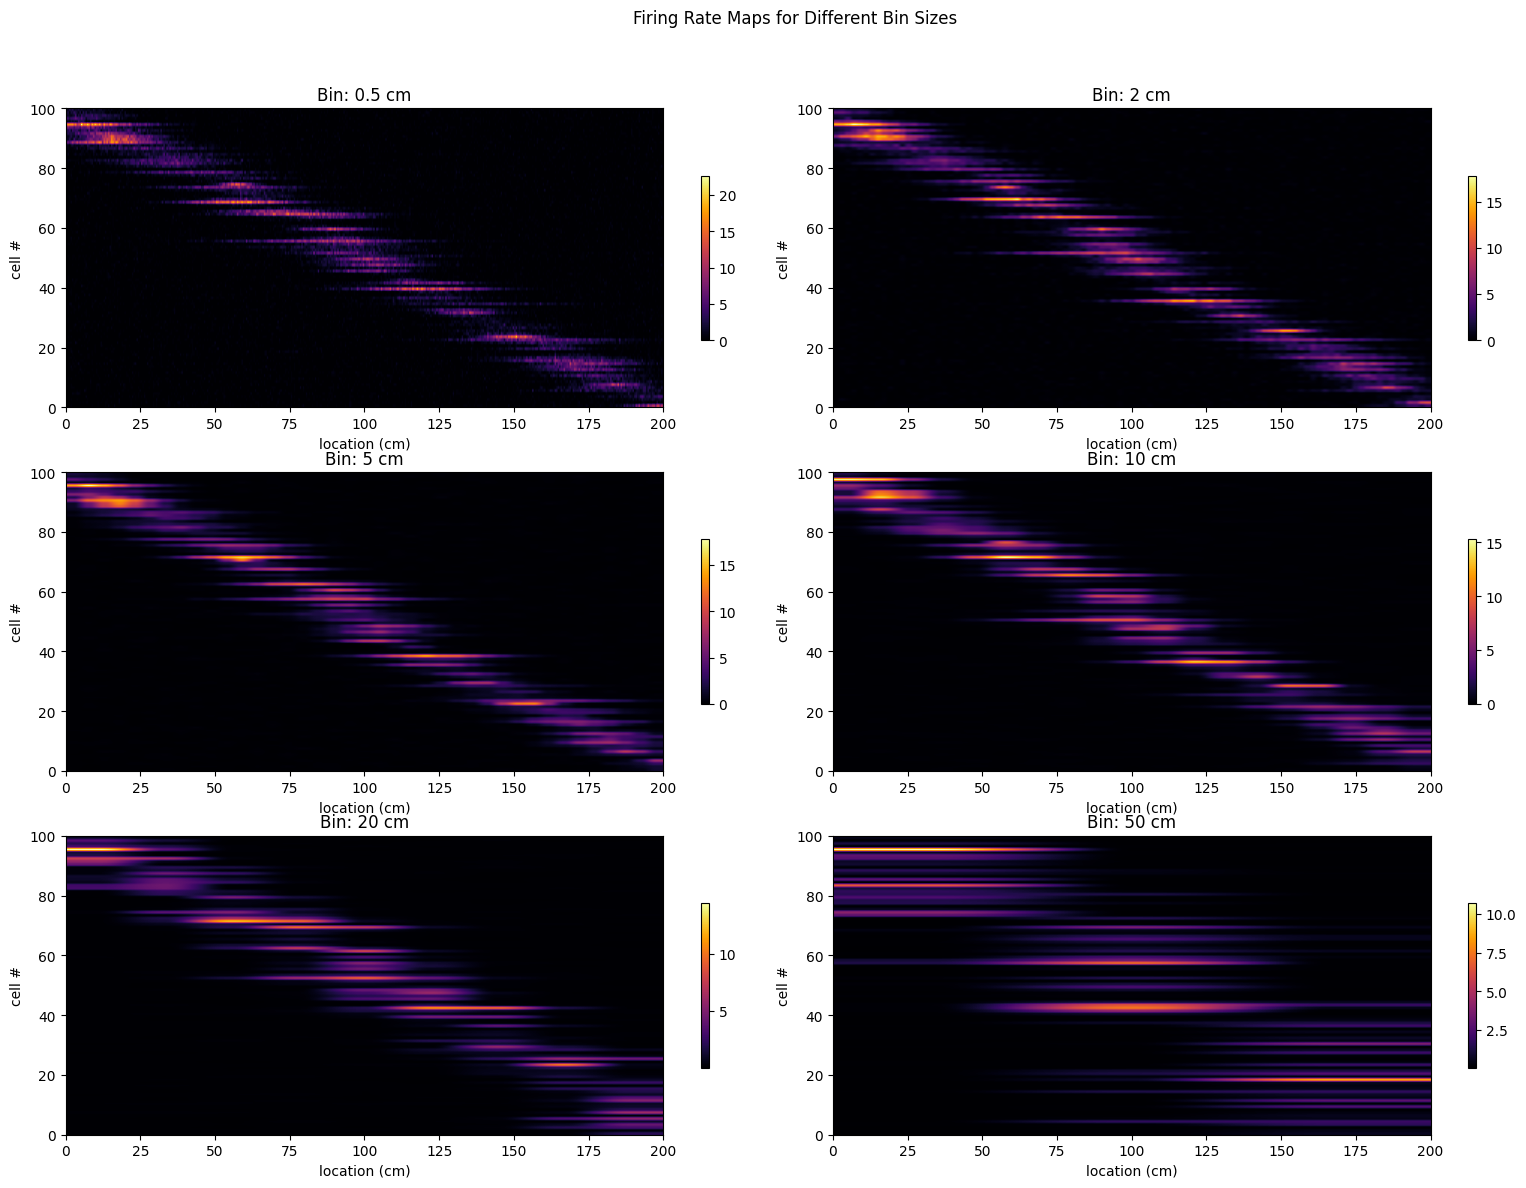

In [17]:
#1A: Changing bin size

bin_values = [0.5, 2, 5, 10, 20, 50]

plt.figure(figsize=(16, 12))

for idx, i in enumerate(bin_values):
    space_bins = np.arange(0.,200.,i)
    
    # compute histogram for each cell
    spikes_hist = [np.histogram(s, space_bins)[0] for s in spike_positions]
    
    # matrix of floating point numbers
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    
    # occupancy histogram
    occupancy = np.histogram(x, space_bins)[0] /  fps 
    firing_rate_maps = spikes_hist / occupancy 
    
    # plot results next to each other
    peak_locations = firing_rate_maps.argmax(axis=1)
    ix = np.argsort(peak_locations)
    plt.subplot(3, 2, idx + 1)
    plt.imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
    plt.title(f'Bin: {i} cm')
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')
    plt.colorbar(shrink = 0.5)
    
plt.suptitle("Firing Rate Maps for Different Bin Sizes")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Report:**

Changing the bin size affects the resolution of the firing rate maps. 
- Smaller bin size: The spatial resolution is a lot higher, so we can have a better view of where neurons are active. Fewer spikes and occupancy samples fall into each bin, so the estimates also become more noisy and can include false positives. 

- Larger bin size: The spatial resolution is low and the maps are smooth. Spikes and occupancy are averaged over larger areas so the firing rate becomes more smooth and stable. There is more data per bin so power increases, however, space fields also merge and appear larger than they are. 

100%|█████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


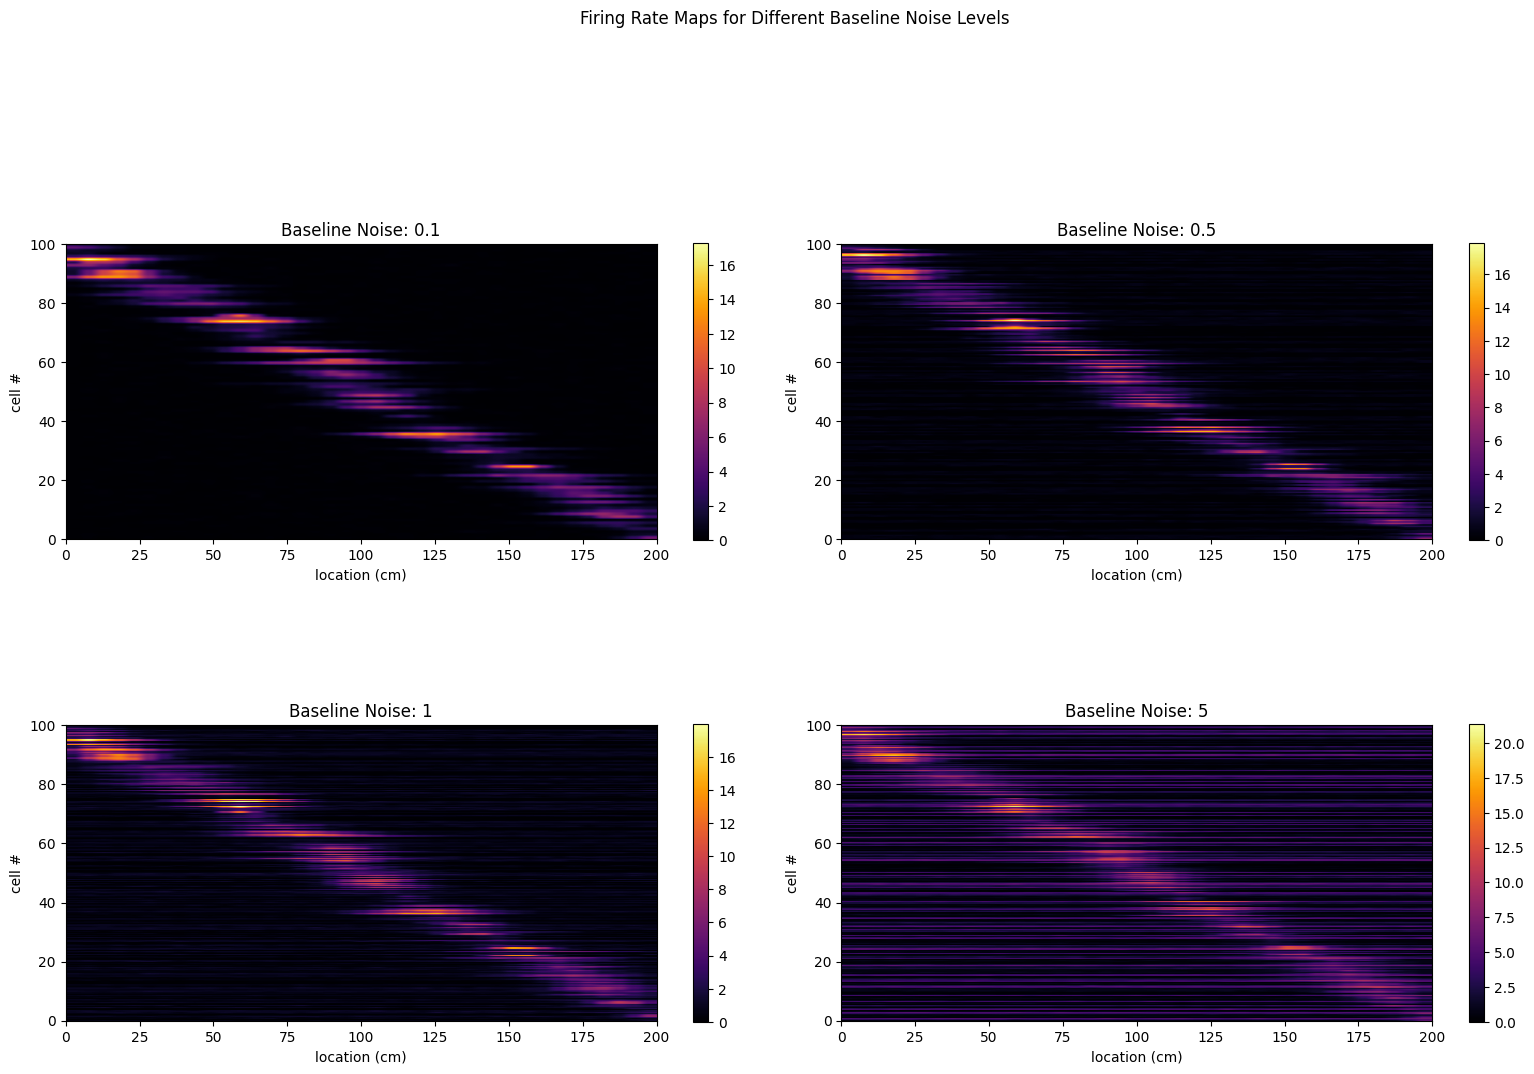

In [19]:
#2A: Changing noise level


baseline_noise = [0.1, 0.5, 1, 5]
spikes = []
plt.figure(figsize=(16, 12))

for idx, level in enumerate(baseline_noise):
    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + level # add constant noise firing here
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc) 
        t_sp = t_sampling[sp]
        spikes.append(t_sp)

    spike_positions = [np.interp(s, t, x) for s in spikes]

    space_bins = np.arange(0., 200., 5.)

    # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

    # put them together into a matrix of floating point numbers (for plotting)
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps 

    firing_rate_maps = spikes_hist / occupancy 
    
    # plot results next to each other
    peak_locations = firing_rate_maps.argmax(axis=1)
    ix = np.argsort(peak_locations)
    plt.subplot(2, 2, idx+1)
    plt.imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
    plt.title(f'Baseline Noise: {level}')
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')
    plt.colorbar(shrink = 0.5)
    
plt.suptitle("Firing Rate Maps for Different Baseline Noise Levels")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Report:**

- The variable 'noise_firing_rate' determines the amount of baseline noise. It represents the activity in the background when a specific neuron is not firing in response to a location. 

- Changing the baseline noise affects the firing maps:
    - Low baseline noise (e.g. 0.1): When there is very little background noise, the spatial fields are distinctly defined and there is a high contrast between in-field and out-field firing. The spatial resolution is therefore a lot higher. 
    - High background noise (e.g. 5): The spikes are spread out throughout all spatial bins, as represented by horizontal lines in the firing map. As such, the map includes more false positives, as background noise is falsely detected as real place fields.

- The best approach for firing maps when the background noise is high is to


In [22]:
# 1C: Small Binning and Gaussian smoother



$$ c_{pf} = \frac{1}{N_{spikes}} \sum_{i} L_i $$ 

where the sum on $i$ runs on all spikes emitted by a cell and $L_i$ is the location at which the i-th spike was emitted. Calculate this for each cell. Compare with the "true" place field centers from the simulations (which variables are we talking about?) 

In [ ]:
# 1D: Place field centre - centre of mass

cpf = (1/)

**Report**:

In the simulation, the place field paramters are represented by 'pf_center' and 'pf_size'.

## Exercise 2 - mutual information
---
A - Implement the mutual information formula discussed in the lesson, and apply it to the place cell data we simulated.

B - Adapt the simulation so that you can systematically vary 1) Peak firing rate, 2) place cell size 3) baseline noise. 
Study how mutual information vary with these parameters. Use both definition of mutual information above, and discuss the differences between them. Make some plots to show how the dependency goes.

**Skagg's Formula:**

$$ I = \sum_x \lambda(x) \log_2 \frac{\lambda(x) + \epsilon}{\lambda} p_{occ}(x) $$ 

Where $\epsilon$ is a very small number (e.g. $10^{-15}$) This small number avoids infinities (and NaNs) when $\lambda(x) = 0$.

where $\lambda(x)$ is the firing rate map (as defined above, with some binning precision) $\lambda$ is the average firing rate of the neuron, and $p_{occ}(x)$ is the occupancy as defined above. Information from this formula is expressed in bits per second. An alternative definition is expressed in bits/spike:

$$ I_s = \frac{I}{\lambda}$$ 


In [41]:
# 2A: Mutual Information for each cell


def compute_mutual_information(firing_rate_maps, occupancy, epsilon = 1e-15):
    avg_firing_rate = np.mean(firing_rate_maps, axis=1)
    spatial_info = []

    for i in range(n_cells):
        # Firing rate map for current cell (lambda(x))
        lambda_x = firing_rate_maps[i, :]

        # Occupancy probability
        p_occ_x = occupancy / np.sum(occupancy)

        #Spatial information (I) using Skagg's formula
        I = np.sum(lambda_x * np.log2((lambda_x + epsilon) / avg_firing_rate[i]) * p_occ_x)

        spatial_info.append(I)

    return np.array(spatial_info)
    

In [47]:
def simulation_with_MI(peak_firing_rate, place_cell_size, baseline_noise):
    n_cells=100
    track_length=200.
    fps=30 # the number of "video frames" per second, i.e. animal position 30 times per second
    n_runs=20
    
    pf_centers = np.random.rand(n_cells) * track_length 
    pf_size = np.full(n_cells, place_cell_size)  # use the provided place cell size
    pf_rate = np.full(n_cells, peak_firing_rate) # use provided peak firing rate
    
    bins = np.arange(0., track_length)
    true_firing_rate_maps = np.zeros((n_cells, len(bins)))

    for i in range(n_cells):
        true_firing_rate_maps[i, :] = pf_rate[i] * np.exp(-((bins - pf_centers[i])**2) / (2 * pf_size[i]**2))
        
    n_runs = 20 
    av_running_speed = 10 # the average running speed (in cm/s)
    running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
    running_speed_b = np.random.chisquare(10, size=n_runs) 

    stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
    stopping_time_b = np.random.chisquare(15, size=n_runs)

    x = np.array([])
    for i in range(n_runs):
        stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0. # effectively same as using a np.zeros; for flexibility 
        run_length = len(bins) * fps / running_speed_a[i]
        run1 = np.linspace(0., float(len(bins)-1), int(run_length))
        stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.) #other end of track = last bin
        run_length = len(bins) * fps / running_speed_b[i]
        run2 = np.linspace(len(bins)-1., 0., int(run_length))
        x = np.concatenate((x, stop1, run1, stop2, run2))
    t = np.arange(len(x))/fps
    
    # Sampling
    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x)) # interpolate here because there are more neural positions than video positions, due to fps = 30
    
    # Simulate spike trains
    spikes = []

    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i, x_sampling.astype(np.int32)] + baseline_noise  # Add baseline noise
        spikes_loc = np.random.poisson(inst_rate / sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)

    spike_positions = [np.interp(s, t, x) for s in spikes]
    
    # Compute histograms for each cell
    space_bins = np.arange(0., track_length, 5.)
    spikes_hist = [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)

    # Occupancy histogram
    occupancy = np.histogram(x, space_bins)[0] / fps

    # Calculate firing rate maps
    firing_rate_maps = spikes_hist / occupancy

    # Compute mutual information: Bits per second
    spatial_info = compute_mutual_information(firing_rate_maps, occupancy)
    bits_per_spike = spatial_info / avg_firing_rate
    
    return spatial_info, bits_per_spike    

100%|█████████████████████████████████████████| 100/100 [01:03<00:00,  1.57it/s]


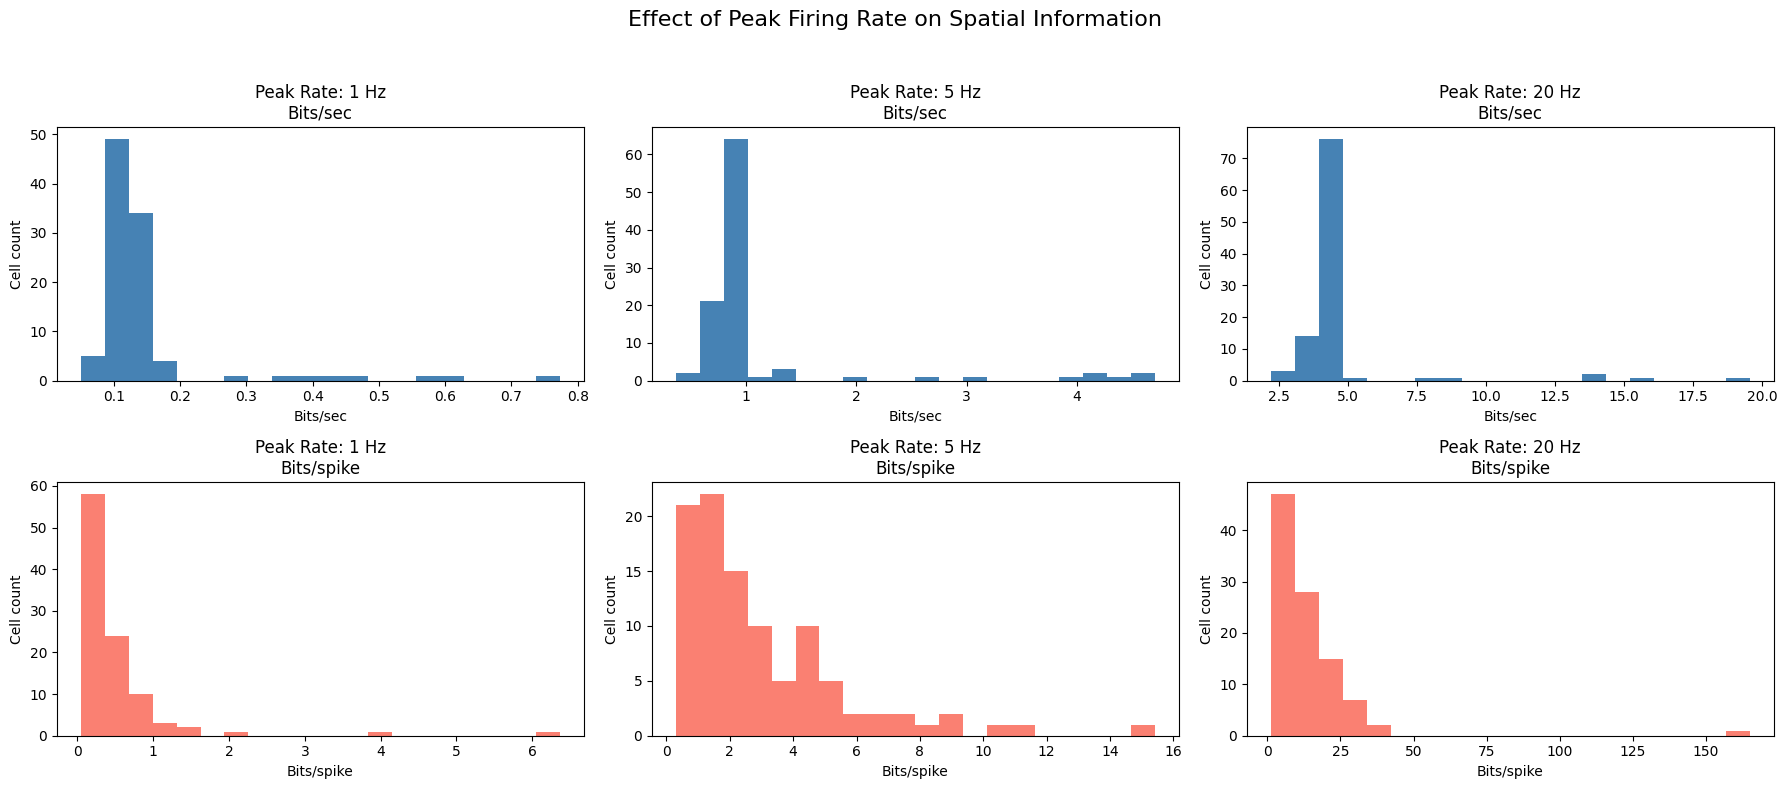

100%|█████████████████████████████████████████| 100/100 [00:59<00:00,  1.67it/s]


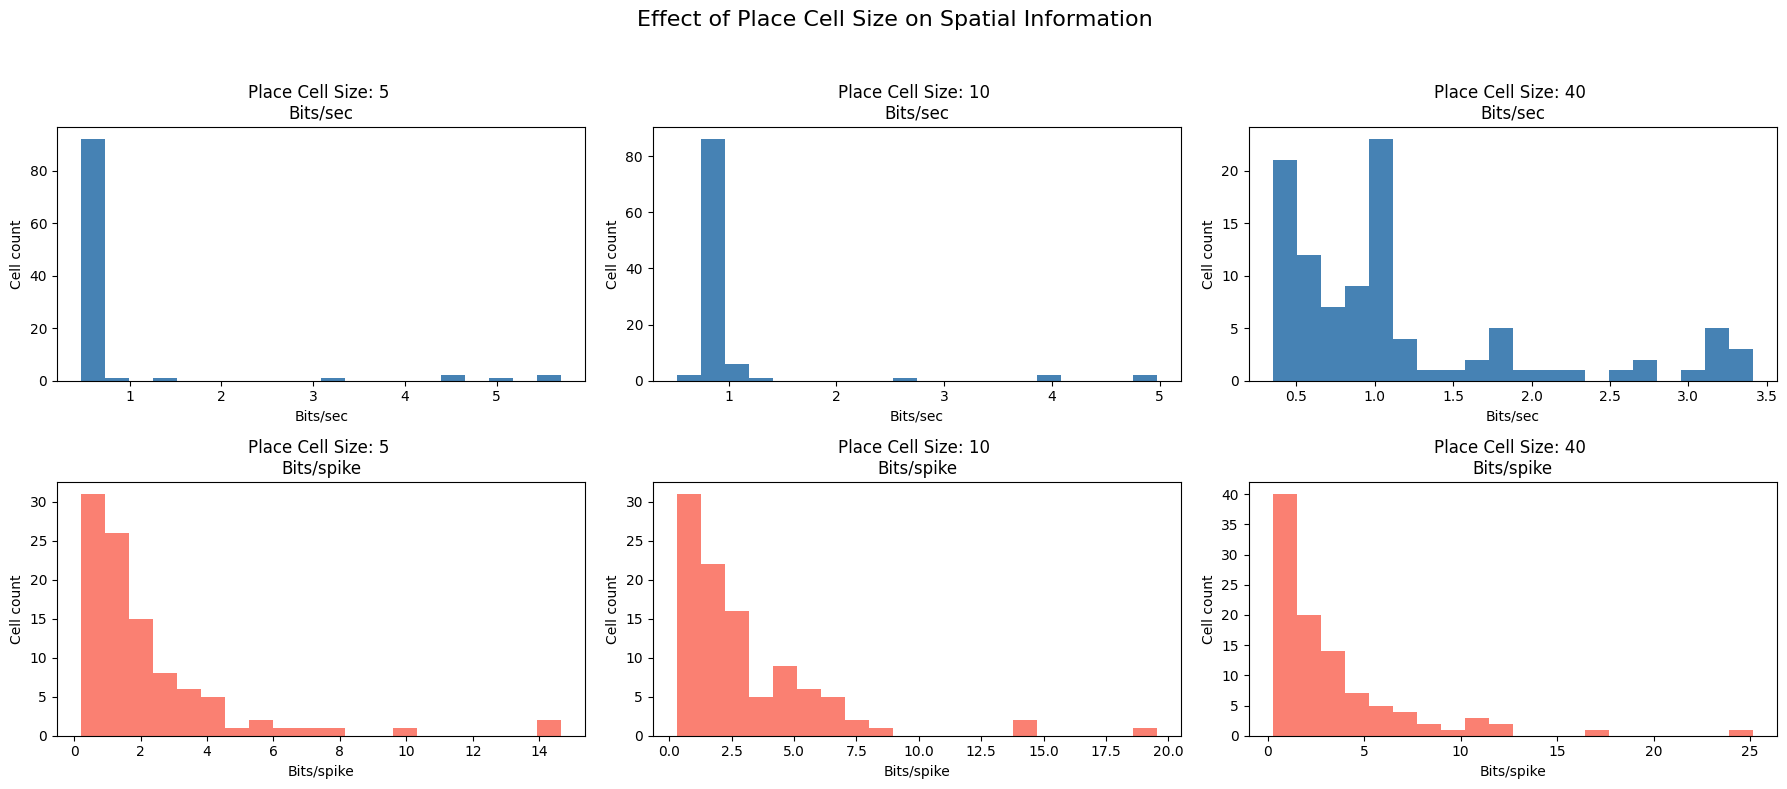

100%|█████████████████████████████████████████| 100/100 [01:13<00:00,  1.37it/s]


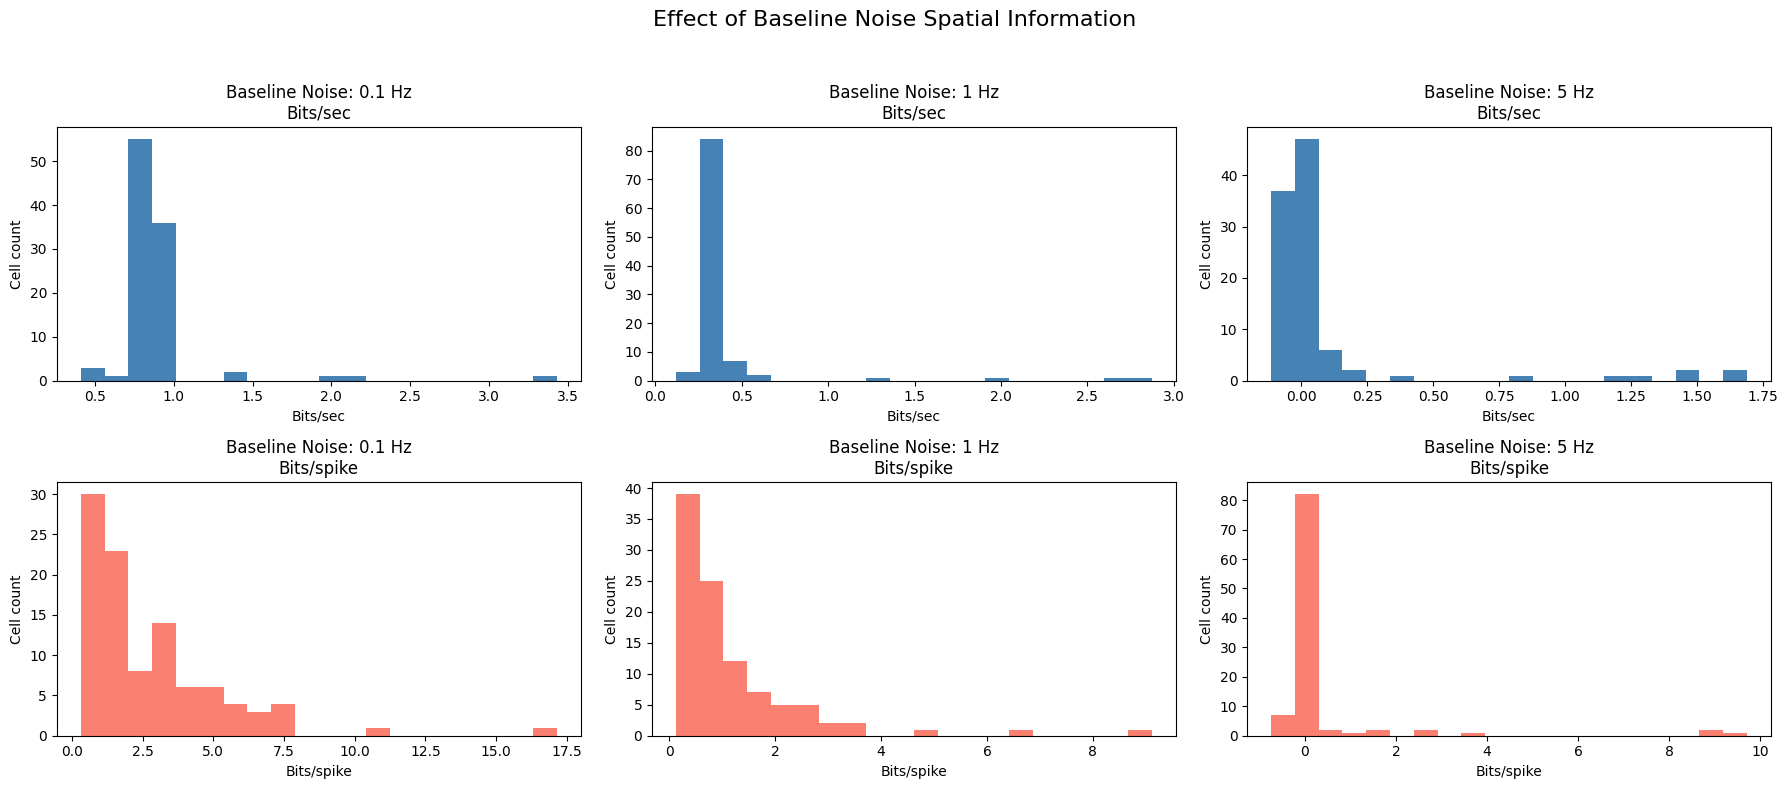

In [51]:
# examine how MI changes for different paramter inputs

# default values
# peak firing rate = 5
# place cell size = 10
# noise = 0.1

peak_firing_rates = [1, 5, 20]
place_cell_sizes = [5, 10, 40]
noise_levels = [0.1, 1, 5]

# peak firing rates

fig, axs = plt.subplots(2, 3, figsize=(18, 8))
fig.suptitle("Effect of Peak Firing Rate on Spatial Information", fontsize=16)

for i, rate in enumerate(peak_firing_rates):
    mi_bps, mi_bpspk = simulation_with_MI(rate, 10, 0.1)
    
    axs[0, i].hist(mi_bps, bins=20, color='steelblue')
    axs[0, i].set_title(f"Peak Rate: {rate} Hz\nBits/sec")
    axs[0, i].set_xlabel("Bits/sec")
    axs[0, i].set_ylabel("Cell count")

    axs[1, i].hist(mi_bpspk, bins=20, color='salmon')
    axs[1, i].set_title(f"Peak Rate: {rate} Hz\nBits/spike")
    axs[1, i].set_xlabel("Bits/spike")
    axs[1, i].set_ylabel("Cell count")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# place cell sizes

fig, axs = plt.subplots(2, 3, figsize=(18, 8))
fig.suptitle("Effect of Place Cell Size on Spatial Information", fontsize=16)

for i, size in enumerate(place_cell_sizes):
    mi_bps, mi_bpspk = simulation_with_MI(5, size, 0.1)
    
    axs[0, i].hist(mi_bps, bins=20, color='steelblue')
    axs[0, i].set_title(f"Place Cell Size: {size} \nBits/sec")
    axs[0, i].set_xlabel("Bits/sec")
    axs[0, i].set_ylabel("Cell count")

    axs[1, i].hist(mi_bpspk, bins=20, color='salmon')
    axs[1, i].set_title(f"Place Cell Size: {size} \nBits/spike")
    axs[1, i].set_xlabel("Bits/spike")
    axs[1, i].set_ylabel("Cell count")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# noise levels

fig, axs = plt.subplots(2, 3, figsize=(18, 8))
fig.suptitle("Effect of Baseline Noise Spatial Information", fontsize=16)

for i, noise in enumerate(noise_levels):
    mi_bps, mi_bpspk = simulation_with_MI(5, 10, noise)
    
    axs[0, i].hist(mi_bps, bins=20, color='steelblue')
    axs[0, i].set_title(f"Baseline Noise: {noise} Hz\nBits/sec")
    axs[0, i].set_xlabel("Bits/sec")
    axs[0, i].set_ylabel("Cell count")

    axs[1, i].hist(mi_bpspk, bins=20, color='salmon')
    axs[1, i].set_title(f"Baseline Noise: {noise} Hz\nBits/spike")
    axs[1, i].set_xlabel("Bits/spike")
    axs[1, i].set_ylabel("Cell count")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()





**Report**:

To do this question, I made a function to comput mutual information, and then also a function that included the simulation, using peak firing rate, place cell size, and baseline noise as parameter inputs.

Regarding the differences between the mutual information in bits/s and bits/peak, we can observe the following trends:

1) Peak Firing Rate
- Bits/s: increases with increasing firing rate
- Bits/peak: becomes more distributed. more cells are showing higher bits/peak with increasing peak firing rate, but low firing cells are most abundant --> bits/peak favors low firing cells.

2) Place Cell Size
- Bits/s: becomes more distributed/decreases with increasing place cell size
- Bits/peak: increases and becomes more distributed. however, low firing cells always highest. 

3) Baseline Noise
- Bits/s: gradually decreases with more noise. the noise adds uninformative spikes
- Bits/peak: drops sharply with increasing noise. indiviudal spikes are less informative, due to the additional random noise. becomes more 'peaky' and less distributed. 

Overall, the values for bits/s are more distributed than for bits/peak. This is because bits/peak favors low firing cells. 



## Exercise 3 - working with real data
---
Load the data from `linear_track_data.pickle`. It contains neural recordings from a mouse running on a linear track.
- `x` contains the position of the animal
- `t` contains the corresponding times, in seconds
- `spikes` contains a list of lists. Each list contains the timestamps of the spikes emitted by a neuron.

A - Visualiaze the position a s a function of time. Plot the spike of a selected cell in space.

B - Calculate the firing rate maps for all the cells, and plot them sorted by increasing peak positon.

C - Calculate the spatial information for each cell, and plot the distribution. Plot the firing rate maps of the 5 cells with lower spatial information, and the firing rate maps of the 5 cells with higher spatial information. Comment on the differences.

In [28]:
# load data --> doesnt work
# download_data('https://surfdrive.surf.nl/files/index.php/s/z7mMiznEWOT0Iak')
# with open('data/linear_track_data.pickle', 'rb') as handle:
#     data = pickle.load(handle)